In [1]:
from game import MOVES_FILE
import json
from x2 import make_state, apply_move, place
import numpy as np
from numpy.typing import NDArray
from typing import Tuple

with open(MOVES_FILE, "r") as f:
    moves = [json.loads(l) for l in f.readlines()]


def check_move(move) -> bool:
    state = make_state(seed=0)
    state.grid = np.array(move["before"])

    place(state, move["play"], move["next_value"])

    return state.grid.tolist() == move["after"]


for m in moves:
    check_move(m)

moves = [m for m in moves if check_move(m)]

len(moves)

113

In [2]:
def moves_to_xy(moves: list) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    all_befores = np.array([m["before"] for m in moves]).reshape((len(moves), -1))

    y = np.array([int(m["play"]) for m in moves])

    all_next_value = np.array([m["next_value"] for m in moves]).reshape((len(moves), 1))

    x = np.concatenate([all_next_value, all_befores], axis=1)
    return x, y

x, y = moves_to_xy(moves)

def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

y_oh = get_one_hot(y, 5)

In [28]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 5),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = NeuralNetwork().to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

X = torch.FloatTensor(x).to(device)
y = torch.FloatTensor(y_oh).to(device)


for e in range(2000):

    print(f'epoch: {e+1}')

    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"loss: {loss.item():>7f}")


Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
)
epoch: 1
loss: 1.519000
epoch: 2
loss: 1.511676
epoch: 3
loss: 1.505149
epoch: 4
loss: 1.499388
epoch: 5
loss: 1.494231
epoch: 6
loss: 1.489133
epoch: 7
loss: 1.484331
epoch: 8
loss: 1.479713
epoch: 9
loss: 1.475181
epoch: 10
loss: 1.470639
epoch: 11
loss: 1.466048
epoch: 12
loss: 1.461537
epoch: 13
loss: 1.457086
epoch: 14
loss: 1.452728
epoch: 15
loss: 1.448422
epoch: 16
loss: 1.444123
epoch: 17
loss: 1.439893
epoch: 18
loss: 1.435588
epoch: 19
loss: 1.431222
epoch: 20
loss: 1.426837
epoch: 21
loss: 1.422384
epoch: 22
loss: 1.417955
epoch: 23
loss: 1.413446
epoch: 24
loss: 1.408930
epoch: 25
loss: 1.404421
epoch: 26
loss: 1.399880
epoch: 27
loss: 1.395436
epo

In [30]:
import numpy as np

cpu_model = model.to("cpu")

def infer(grid: NDArray[np.float64], next_value: int) -> int:
    v = np.concatenate([[next_value], grid.ravel()]).reshape((1, -1))
    return cpu_model(torch.FloatTensor(v).to("cpu")).detach().cpu().numpy().argmax()

from typing import List
import numpy as np

rewards: List[int] = []

plays = []

for s in range(1000):
    state = make_state(seed=s)
    r = 0

    ps = []

    while True:

        move = infer(state.grid, state.next_play)
        ps.append(move)

        (state, reward, done) = apply_move(state, move)

        r += reward

        if done:
            rewards.append(r)
            plays.append(ps)
            break
            
np.mean(rewards), np.std(rewards)



(13.73, 5.880909793560857)

array([[<AxesSubplot:title={'center':'reward'}>]], dtype=object)

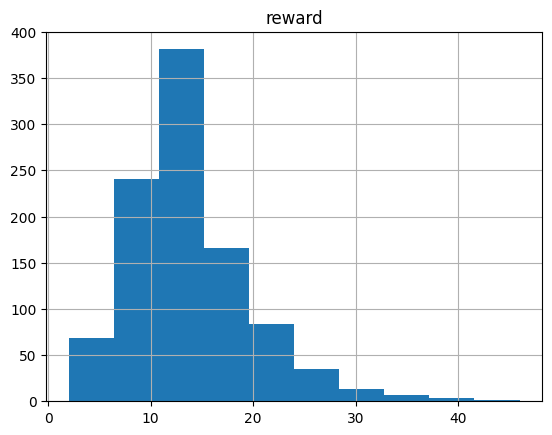

In [31]:
import pandas as pd

df = pd.DataFrame(rewards, columns=['reward'])
df.hist()

In [32]:
state = make_state(seed=2)
moves = plays[2]

r = 0

for m in moves:

    (state, reward, done) = apply_move(state, m)

    r += reward


print(r)

7
